# Goal
Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most eﬃcient is using emails. Emails are great cause they are free and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this. Challenge Description

The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past. They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site. 

You are in charge of ﬁguring out how the email campaign performed and were asked the following questions: 
1)What percentage of users opened the email and what percentage clicked on the link within the email? 
2)The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email? 
3)By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). 
4)How would you test that? Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.


In [164]:
#data read from input file 
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


emailOpen_file='data/email/email_opened_table.csv'
email_file='data/email/email_table.csv'
linkClicked_file='data/email/link_clicked_table.csv'

emailOpen=pd.read_csv(emailOpen_file)
email=pd.read_csv(email_file,index_col="email_id")
linkClicked=pd.read_csv(linkClicked_file)


In [165]:
emailOpen.head()
linkClicked.head()
email.head()
#emailOpen[emailOpen["email_id"]==966622] 

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [166]:
data=email
data["email_status"]=0
email_open_id=emailOpen["email_id"]

data.loc[email_open_id,"email_status"]=1

In [167]:
data["link_status"]=0

data.loc[linkClicked["email_id"],"link_status"]=1
data.groupby(["email_status","link_status"]).size()
#found 50 records with email not opened but links get clicked, we treat this data as error data


email_status  link_status
0             0              89605
              1                 50
1             0               8276
              1               2069
dtype: int64

In [168]:
data=data[(data["email_status"]==1)| (data["link_status"]==0)]

data.groupby(["email_status","link_status"]).size()

email_status  link_status
0             0              89605
1             0               8276
              1               2069
dtype: int64

In [169]:
data.head()
data.groupby("email_text")["email_status"].mean() #check based on long/short text email, user open email ratio


email_text
long_email     0.091228
short_email    0.115911
Name: email_status, dtype: float64

for short emails, open ratio is 11%, wile for long ones open ratio is 9% 

In [170]:
data.groupby("email_text")["link_status"].mean() #check based on long/short text email, user open email ratio

email_text
long_email     0.017991
short_email    0.023440
Name: link_status, dtype: float64

for short email, link clicked ratio is 2%, compared to long ones, which is 1.8%

In [171]:
data.groupby(["email_text","email_version"])["email_status"].mean() #check based on long/short text email, user open email ratio

email_text   email_version
long_email   generic          0.070856
             personalized     0.111755
short_email  generic          0.088028
             personalized     0.144035
Name: email_status, dtype: float64

In [172]:
data.groupby(["email_text","email_version"])["link_status"].mean() #check based on long/short text email, user open email ratio


email_text   email_version
long_email   generic          0.013085
             personalized     0.022934
short_email  generic          0.015987
             personalized     0.030957
Name: link_status, dtype: float64

In [173]:
data.groupby("email_status")["link_status"].mean()
#among emails which are not opened, there are some error message showing link were clicked
#among emails which are opened, 20% of them with links clicked 

email_status
0    0.0
1    0.2
Name: link_status, dtype: float64

In [174]:
data["email_status"].mean() #10%
data["link_status"].mean() #2.1%

0.020700350175087544

## Question 1:
    Overall 10% email were opened, 2.1% of link get clicked. 
    For different email settings, open ratio and click ratio are different. Short message with personalized content with highest open ratio and click ratio, which are 14% and 3.1% respectively. 
    
    

## step2 build a decision tree to optimize email campaign


In [175]:
data.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_status,link_status
email_id,,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,0,0
966622,long_email,personalized,12,Sunday,UK,2,1,1
777221,long_email,personalized,11,Wednesday,US,2,0,0
493711,short_email,generic,6,Monday,UK,1,0,0
106887,long_email,generic,14,Monday,US,6,0,0


In [180]:
#trainingdata=data.loc[:,["hour","user_past_purchases"]]
label=data["link_status"]
data_2=data


In [181]:
data_2=data_2.drop(["email_status","link_status"],axis=1) 
data_2.head()


,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [182]:
data_2=pd.get_dummies(data_2, prefix=["email_text","email_version","weekday","user_country"],drop_first=True)


In [185]:
data_2.head()
labels=list(data_2)

#data_3=np.concatenate((data_2, trainingdata),axis=1)


In [214]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



In [249]:
clf = tree.DecisionTreeClassifier(max_depth=10,class_weight ="balanced")#

#class_weight=balanced has improved model performance a lot 
X_train, X_test, y_train, y_test = train_test_split(data_2, label, test_size=0.3)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
#


Accuracy: 63.34%
Confusion matrix:
 [[18581 10772]
 [  221   411]]


In [250]:
print(y_train.mean())#avg click ratio is 2%
print(y_train.count())#total records 69965

print(y_test.mean())#avg click ratio is 2%
print(y_test.count())#total records in test dataset 29985


0.020538840849
69965
0.0210772052693
29985


In [251]:
tn, fp, fn, tp = conf_mat.ravel()
print("precision is {0}".format(tp/(tp+fp)))
print("recall is {0}".format(tp/(tp+fn)))

# when using class_weight=balance, precision can be 3.6%, and recall is 65%
# when not using class_weight=balance, precision can be 12%, but recall is only 0.3%

precision is 0.036752213180720736
recall is 0.6503164556962026


### conclusion for question 3
when using decision tree model to select customer who should receive this camgpaign email, we can expect user click ratio to be improved to 3.6%, which is 1.8 times better than current click ratio. 


In [243]:
importance=clf.feature_importances_
features=list(data_2.columns)

importances = sorted(zip(features, importance), key=lambda x:x[1], reverse=True)
for feature, val in importances:
    print('{0:10s} | {1:.5f}'.format(feature, val))

user_past_purchases | 0.49266
hour       | 0.19218
email_version_personalized | 0.06729
user_country_FR | 0.04679
email_text_short_email | 0.03296
weekday_Sunday | 0.02798
weekday_Saturday | 0.02454
user_country_UK | 0.02323
weekday_Thursday | 0.02165
weekday_Monday | 0.01996
user_country_US | 0.01853
weekday_Wednesday | 0.01762
weekday_Tuesday | 0.01462


In [153]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, data_2, label, cv=10,scoring='f1_macro')


array([ 0.4945416 ,  0.49456659,  0.49461768,  0.49903484,  0.49912765,
        0.49459214,  0.49459214,  0.49922122,  0.49448994,  0.49908059])

In [141]:
cross_val_score(clf, data_2, label, cv=10,scoring='accuracy')

array([ 0.97880212,  0.9788    ,  0.9787    ,  0.9788    ,  0.9788    ,
        0.9788    ,  0.9788    ,  0.9788    ,  0.9788    ,  0.97889789])

In [142]:
cross_val_score(clf, data_2, label, cv=10,scoring='recall_macro')

array([ 0.5       ,  0.5       ,  0.49994892,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ])

In [154]:
cross_val_score(clf, data_2, label, cv=10,scoring='precision_macro')

array([ 0.48939682,  0.48939682,  0.48939894,  0.48939364,  0.572777  ,
        0.48939788,  0.48939788,  0.61444578,  0.4893947 ,  0.54504505])

In [159]:


from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

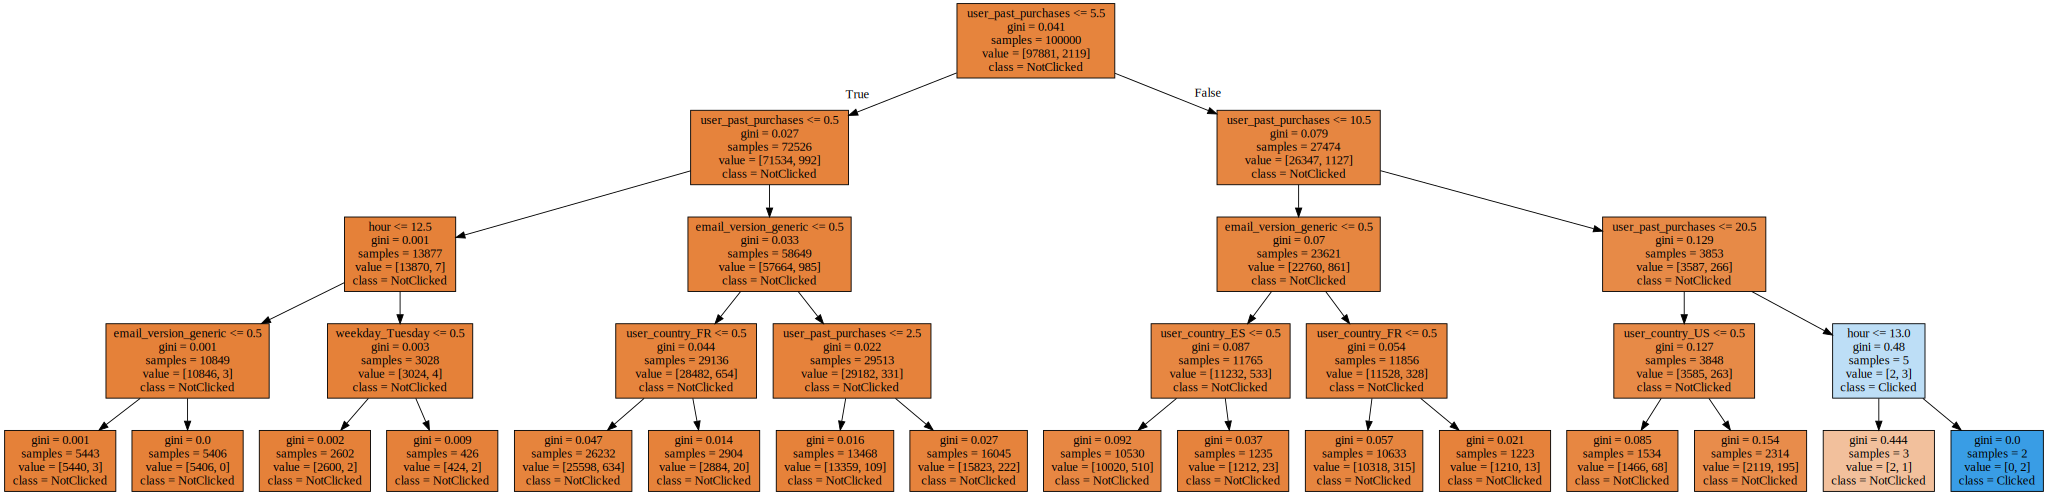

In [162]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , feature_names=labels, class_names=['NotClicked', 'Clicked'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

### Chi squared to check feature importance


### Exploratory analysia and chart plots 

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

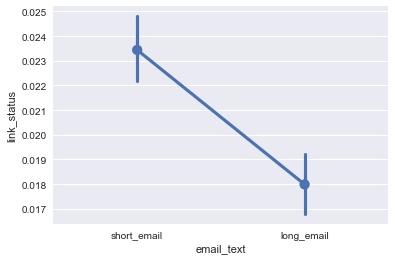

In [196]:

ax = sns.pointplot(x="email_text", y="link_status", data=data)
plt.show() 

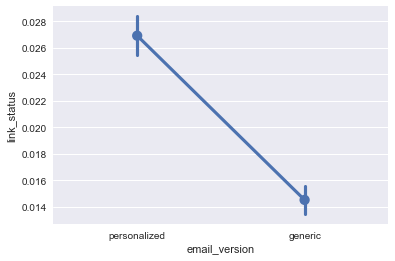

In [197]:
ax = sns.pointplot(x="email_version", y="link_status", data=data)
plt.show() 

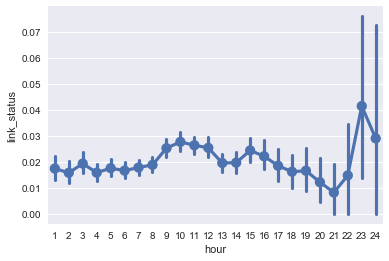

In [198]:
ax = sns.pointplot(x="hour", y="link_status", data=data)
plt.show() 

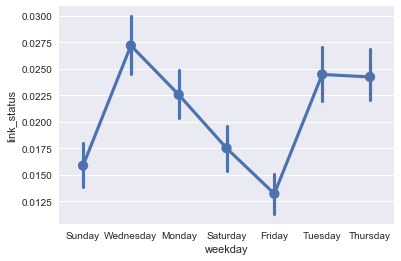

In [199]:
ax = sns.pointplot(x="weekday", y="link_status", data=data)
plt.show() 

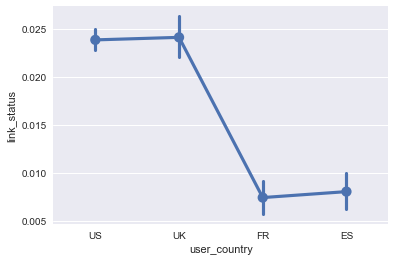

In [200]:
ax = sns.pointplot(x="user_country", y="link_status", data=data)
plt.show() 